## Import lib

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from collections import Counter, OrderedDict
from IPython import display
from tqdm import trange, tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

## Uploat dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
os.chdir("drive/My Drive/Pattern-Mining-from-text-with-RNNs")
!ls

all-the-news	     Cats_vs_Dogs_3.pth
Cats_vs_Dogs_0.pth   Cats_vs_Dogs_4.pth
Cats_vs_Dogs_10.pth  Cats_vs_Dogs_5.pth
Cats_vs_Dogs_11.pth  Cats_vs_Dogs_6.pth
Cats_vs_Dogs_12.pth  Cats_vs_Dogs_7.pth
Cats_vs_Dogs_13.pth  Cats_vs_Dogs_8.pth
Cats_vs_Dogs_14.pth  Cats_vs_Dogs_9.pth
Cats_vs_Dogs_15.pth  char_rnn.ipynb
Cats_vs_Dogs_16.pth  data_etsy.csv
Cats_vs_Dogs_17.pth  README.md
Cats_vs_Dogs_18.pth  test.html
Cats_vs_Dogs_19.pth  Untitled.ipynb
Cats_vs_Dogs_1.pth   Vsevolod_RNN_OneHotEncode_NewsDataset.ipynb
Cats_vs_Dogs_2.pth


In [0]:
path = "all-the-news/articles1.csv"
df = pd.read_csv(path, index_col=0)

In [5]:
print("Max length of article:", df[df['content'].str.len() > 10]['content'].str.len().max())

Max length of article: 149346


## Generate vocabulary

In [6]:
%%time
vocabulary, counts = np.unique(bytearray(''.join(df['content']).encode('unicode-escape')), return_counts=True)
n_letters = len(vocabulary)

print("Length of vocabulary:", len(vocabulary))
print("Vocabulary:", bytearray(vocabulary).decode('unicode-escape'), '\n')

Length of vocabulary: 91
Vocabulary:  !#$%&()*+,.0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ 

CPU times: user 7.69 s, sys: 423 ms, total: 8.11 s
Wall time: 8.12 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: invalid escape sequence '\]'
  """


## OneHotEncode of the data and transform to the tensor

In [7]:
# article -> tensor

import torch

id2char = dict(enumerate(bytearray(vocabulary).decode('unicode-escape')))
char2id = {tok: i for (i, tok) in id2char.items()}

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(n_letters, dtype=torch.long)
    tensor[char2id.get(letter, 0)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line): 
    indeces = []
    for li, letter in enumerate(line):
        indeces += [[li, char2id.get(letter, 0)]]
    return torch.sparse_coo_tensor(np.array(indeces).T,
                                   torch.ones(len(indeces)),
                                   size=(len(line), n_letters)).to_dense()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\]'
  after removing the cwd from sys.path.


## DataLoader

In [0]:
#Change class name 
class DataLoader(Dataset):
    def __init__(self, texts, max_len=100):
        self.texts = texts
        self.max_len = max_len

    def __getitem__(self, idx):
        x = self.texts[idx][:self.max_len]
        return lineToTensor(x[:-1]), letterToTensor(x[-1])
    
    def __len__(self): 
        return (len(self.texts))

## Model architecture 

In [0]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, n_layers=1):
        super(CharRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.rnn = nn.RNN(vocab_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        out, hidden = self.rnn(input, hidden)
        out = self.decoder(out)
        return out, hidden
    
    def get_params(self):
        return (self.rnn._parameters['weight_ih_l0'],
                self.rnn._parameters['weight_hh_l0'],
                self.rnn._parameters['bias_ih_l0'],
                self.rnn._parameters['bias_hh_l0'])

## Initialize the model

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, n_letters).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.001)

cuda:0


In [0]:
BATCH_SIZE = 1

train_text, test_text = train_test_split(df[df['content'].str.len() > 10]['content'].values, test_size=0.2, shuffle=False)

trainset = DataLoader(train_text.copy())
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=4)

testset = DataLoader(test_text.copy())
testloader = torch.utils.data.DataLoader(testset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          num_workers=4)

## Train

Train examples: 39964
Validation examples: 9992
Start training...
Epoch  0: Train loss   4.58, Test loss:   4.57, test accuracy = 3.87
Epoch  1: Train loss   4.42, Test loss:   4.47, test accuracy = 4.22
Epoch  2: Train loss   3.57, Test loss:   4.41, test accuracy = 5.48
Epoch  3: Train loss   2.72, Test loss:   4.35, test accuracy = 5.72
Epoch  4: Train loss    2.5, Test loss:    4.3, test accuracy = 5.80
Epoch  5: Train loss   2.44, Test loss:   4.31, test accuracy = 5.85
Epoch  6: Train loss   2.42, Test loss:    4.3, test accuracy = 5.86
Epoch  7: Train loss    2.4, Test loss:    4.3, test accuracy = 5.88
Epoch  8: Train loss   2.39, Test loss:    4.3, test accuracy = 5.90
Epoch  9: Train loss   2.39, Test loss:   4.33, test accuracy = 5.90
Epoch 10: Train loss   2.38, Test loss:   4.28, test accuracy = 5.90
Epoch 11: Train loss   2.38, Test loss:   4.26, test accuracy = 5.89
Epoch 12: Train loss   2.38, Test loss:   4.28, test accuracy = 5.90
Epoch 13: Train loss   2.38, Test los

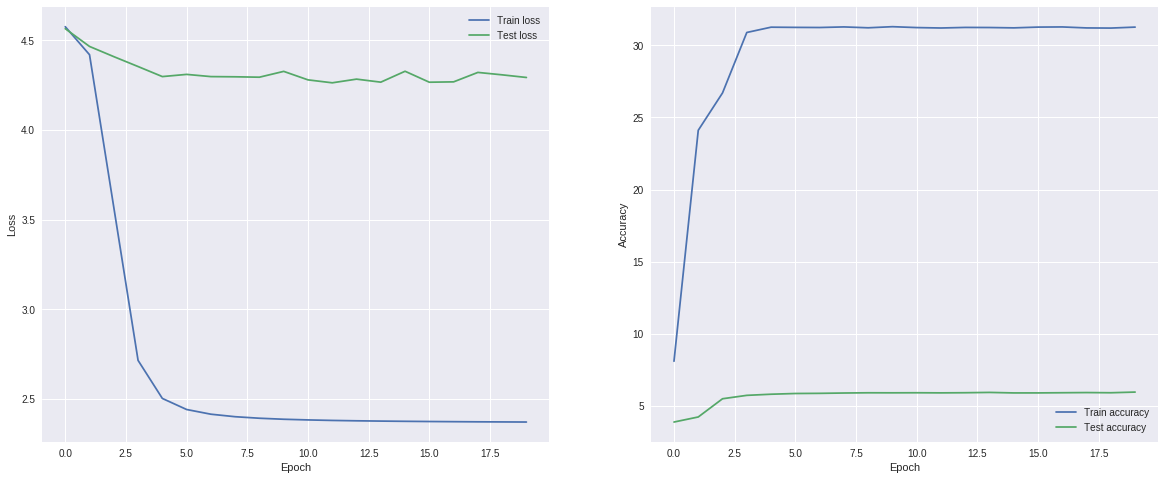

In [17]:
### BEGIN Solution
def train(model, optimizer, criterion, num_epochs=10, silent=False, model_name='Cats_vs_Dogs'):
    print("Train examples: {}".format(len(trainset)))
    print("Validation examples: {}".format(len(testset)))
    print("Start training...")

    train_loss_plot = []
    test_loss_plot = []
    train_accur_plot = []
    test_accur_plot = []

    for epoch in range(num_epochs):
        if (not silent):
            print("Epoch {:2}: ".format(epoch), end='')
        else:
            print('.', end='')

        # train one epoch
        model.train()
        total_train_loss = 0
        correct_examples_train = 0
        for batch_idx, data in enumerate(trainloader):
            input, label = data
            if torch.cuda.is_available():
                input, label = input.cuda(), label.cuda()

            optimizer.zero_grad()
            
            hidden = torch.zeros((input.shape[0], input.shape[1], n_hidden)).to(device)
            pred, _ = model(input, hidden)           
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            _, pred_choice = F.softmax(pred, dim = 1).max(1)
            correct = pred_choice.eq(label).sum()
            correct_examples_train += correct.item()

        model.eval()
        correct_examples_test = 0
        total_test_loss = 0
        for batch_idx, data in enumerate(testloader):
            input, label = data
            if torch.cuda.is_available():
                input, label = input.cuda(), label.cuda()
            
            hidden = torch.zeros((input.shape[0], input.shape[1], n_hidden)).to(device)
            pred, _ = model(input, hidden)
            loss = criterion(pred, label)
            total_test_loss += loss.item()

            _, pred_choice = F.softmax(pred, dim = 1).max(1)
            correct = pred_choice.eq(label).sum()
            correct_examples_test += correct.item()

        torch.save(model.state_dict(), model_name + '_{}.pth'.format(epoch))
        
        if (not silent):
            print('Train loss {:6.3}, Test loss: {:6.3}, test accuracy = {:4.2f}'\
                  .format(total_train_loss / len(trainset), 
                          total_test_loss  / len(testset),
                          correct_examples_test / len(testset)))
        
        train_loss_plot.append(total_train_loss / len(trainset))
        test_loss_plot.append(total_test_loss  / len(testset))

        train_accur_plot.append(correct_examples_train / len(trainset))
        test_accur_plot.append(correct_examples_test / len(testset))

    plt.figure(figsize=(20, 8))
    plt.subplot(1,2,1)
    plt.plot(range(num_epochs), train_loss_plot)
    plt.plot(range(num_epochs), test_loss_plot)
    plt.legend(['Train loss', 'Test loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(range(num_epochs), train_accur_plot)
    plt.plot(range(num_epochs), test_accur_plot)
    plt.legend(['Train accuracy', 'Test accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

train(rnn, optimizer, criterion, num_epochs=20) # RMSprop (default params)
### END Solution 

In [31]:
Wx, Wy, bx, by = rnn.get_params()
Wx.shape, Wy.shape, bx.shape, by.shape

(torch.Size([128, 91]),
 torch.Size([128, 128]),
 torch.Size([128]),
 torch.Size([128]))

In [0]:
hidden = torch.zeros(n_hidden)
idx = 0
output = []
for ch in test_text[idx][:100]:
    out = torch.tanh(Wx.mv(letterToTensor(ch).float().to(device)) + bx + hidden.to(device))
    hidden = Wy.mv(out) + by
    output += [hidden.cpu().data.numpy()]

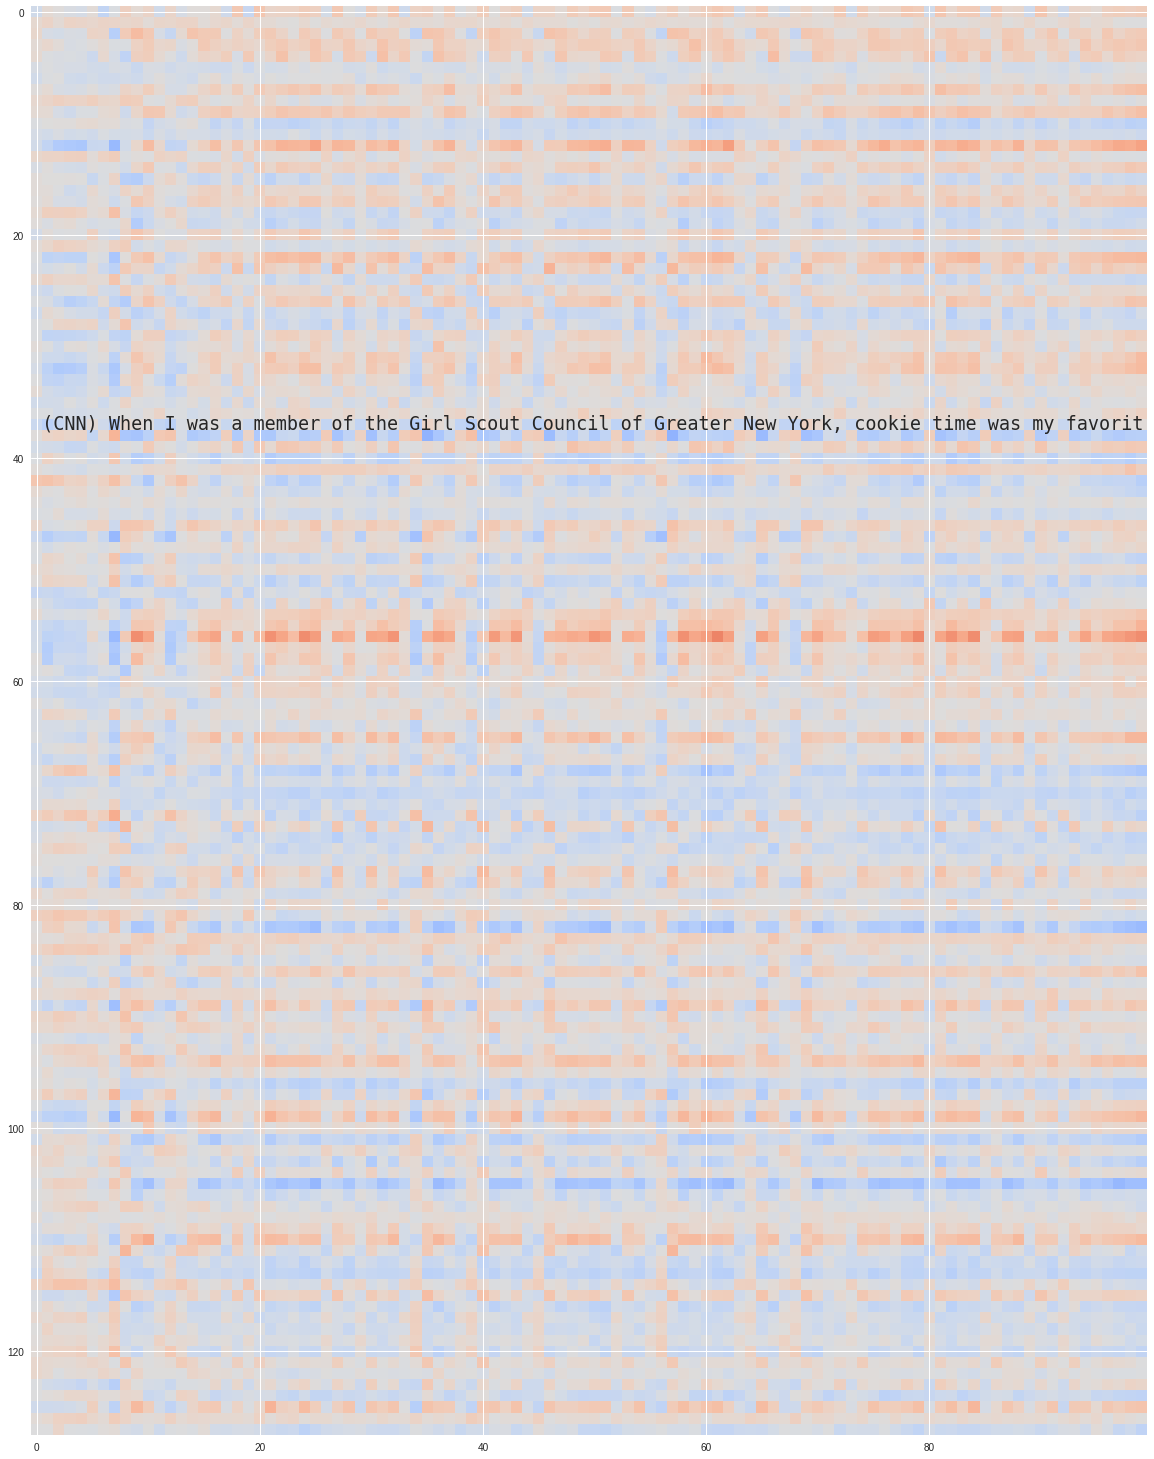

In [145]:
plt.figure(figsize=(20, 30))
plt.imshow(np.array(output).T, cmap='coolwarm', vmin=-1, vmax=1)
plt.text(-0.5, 0.4 + 37, test_text[idx][:100], family='monospace', fontsize=18.56)
plt.show()